# Lesson 2 (and 1) HW
In this lesson we will be looking at implementing the fine tuning method (i.e. replacing the last fully connected softmax layer and then retraining that last layer) in vgg16.

Assuming we have downloaded the data in zip files from Kaggle, and have unzipped them into train/ and test/ subdirectories in the dogscatsredux/ directory in DATA_HOME_PATH. Basically then, what we need to do is this:

1. Create the directory structures that Keras is expecting the photos to be in:
  * valid/ directory
  * cats/ and dogs/ subdirectories in train/, test/, and /valid
  * sample/ directory
  * train/ and valid/ subdirectories in sample/
  * cats/ and dogs/ subdirectories in sample/train/ and sample/valid/
2. Copy & move pictures to the above directories 
  * Move a random 10% of pictures from train/ to valid/
  * Copy 200 random pictures from train/ to sample/train
  * Copy 20 random pictures from valid/ to sample/valid
  * For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/  
  * For test/, move all pics into unknown/
3. Fine-tune the vgg model
  * load the existing model
  * remove the last dense softmax layer
  * replace with 2 class dense softmax layer 
  * retrain last layer's weights
4. Generate predictions
5. Validate predictions
6. Submit to Kaggle

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division,print_function
import os
from shutil import copyfile
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import scipy
from sklearn.metrics import confusion_matrix
# Deep-learning related
import utils; reload(utils) # custom utils
from utils import plots, plot_confusion_matrix
from vgg16 import Vgg16
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image




Using Theano backend.


In [39]:
# constants for directory paths
# assumes they already exist
NBS_HOME_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/nbs'
DATA_HOME_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/data/dogscatsredux'
MODEL_RESULTS_PATH = '/home/honto/Online_Courses/fast_ai/fast_ai_coursework/deeplearning1/results/dogscatsredux'

## 1) Create the directory structures that Keras is expecting the photos to be in:
* valid/ directory
* cats/ and dogs/ subdirectories in train/, test/, and /valid
* sample/ directory
* train/ and valid/ subdirectories in sample/
* cats/ and dogs/ subdirectories in sample/train/ and sample/valid/

In [10]:
%mkdir $DATA_HOME_PATH/train/cats
%mkdir $DATA_HOME_PATH/train/dogs
%mkdir $DATA_HOME_PATH/valid
%mkdir $DATA_HOME_PATH/valid/cats
%mkdir $DATA_HOME_PATH/valid/dogs
%mkdir $DATA_HOME_PATH/test/unknown
%mkdir $DATA_HOME_PATH/sample
%mkdir $DATA_HOME_PATH/sample/train
%mkdir $DATA_HOME_PATH/sample/train/cats
%mkdir $DATA_HOME_PATH/sample/train/dogs
%mkdir $DATA_HOME_PATH/sample/valid
%mkdir $DATA_HOME_PATH/sample/valid/cats
%mkdir $DATA_HOME_PATH/sample/valid/dogs
%mkdir $MODEL_RESULTS_PATH

## 2) Copy & move pictures to the above directories 
* Move a random 10% of pictures from train/ to valid/
* Copy 200 random pictures from train/ to sample/
* For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/ 
* For test/, move all pics into unknown/

In [22]:
%cd $DATA_HOME_PATH/train

/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/train


In [23]:
%%bash
ls | wc -l

25002


In [25]:
# move 2500 from train/ to valid/
# get all the pic filenames (['cat.8033.jpg', 'cat.6541.jpg', ...])
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(2500):
    os.rename(valid_filenames[i], DATA_HOME_PATH + '/valid/' + valid_filenames[i])

In [27]:
# Copy 200 random pictures from train/ to sample/train
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(200):
   copyfile(valid_filenames[i], DATA_HOME_PATH + '/sample/train/' + valid_filenames[i])

In [28]:
# Copy 20 random pictures from valid/ to sample/train
%cd $DATA_HOME_PATH/dogscatsredux/valid
g = glob('*.jpg')
# randomly permute g and get the first  
valid_filenames = np.random.permutation(g)
for i in range(20):
   copyfile(valid_filenames[i], DATA_HOME_PATH + '/sample/valid/' + valid_filenames[i])

/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/valid


In [30]:
# For each of train/, valid/, sample/train, and sample/test, move all cat pics into cats/ and dog pics into dogs/  
%cd $DATA_HOME_PATH/train
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/valid
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/train
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/valid
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $NBS_HOME_PATH

/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/train
/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/valid
/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/sample/train
/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/sample/valid


In [33]:
# For test/, move all pics into unknown/
%cd $DATA_HOME_PATH/test
%mv *.jpg unknown/
%cd $NBS_HOME_PATH

/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs/data/dogscatsredux/test
mv: cannot stat '*.jpg': No such file or directory
/home/honto/Online_Courses/fast_ai/courses/deeplearning1/nbs


## 3) Fine-tune the vgg model
* load the existing model
* remove the last dense softmax layer
* replace with 2 class dense softmax layer 
* retrain last layer's weights

In [3]:
BATCH_SIZE = 32
NO_EPOCHS = 1

In [4]:
# load the existing model
#
# use the helper Vgg class provided by fast.ai. The constructor does the following:
# creates a CNN with the vgg architecture
# downloads and adds the pre-trained weights for all layers
vgg = Vgg16()
model = vgg.model

In [5]:
# remove the last dense softmax layer
model.pop()
# set the other layer weights to NOT get trained during fine tuning
for l in model.layers:
    l.trainable = False
# add the dense layer
# input dimension is detected from the last layer in the current model
model.add(Dense(output_dim=2, activation='softmax'))
# let's see the layers 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [1]:
# to configure the learning process (optimizer, loss, metric)
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

NameError: name 'model' is not defined

In [33]:
# retrain last layer's weights
#
# First we get the images from train and valid in batches. 
# We have to use Keras' generator methods when doign things in batches.
# IMageDataGenerator() has imiage augmentation capabilities but we will leave them all our for now
img_gen = image.ImageDataGenerator()
# read from directory
# note that we can pass a list of sub directories of classes through the "classes" argument 
# but it is now inferred. Also, the model we know takes images of size 224, 224. It gets resized (HOW?)
train_batches = img_gen.flow_from_directory(DATA_HOME_PATH + '/sample/train/', 
                                            target_size=(224,224),
                                            class_mode='categorical', 
                                            # above for generator return 2-D OHE truth labels
                                            batch_size = BATCH_SIZE,
                                            shuffle=True
                                           )
val_batches = img_gen.flow_from_directory(DATA_HOME_PATH + '/sample/valid/', 
                                          target_size=(224,224),
                                          class_mode='categorical',
                                          batch_size = 1,
                                          shuffle=False
                                         )
# note that above _batches are Python generators that yield 
# Tuples of (x, y) where x is a numpy array of image data and y is a numpy array of corresponding labels

Found 200 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [34]:
# now we fit the model
model.fit_generator(train_batches, 
                    samples_per_epoch=train_batches.nb_sample, 
                    nb_epoch=NO_EPOCHS, 
                    verbose=1, 
                    validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample
                   )


Epoch 1/1
200/200 [==============================] - 97s - loss: 0.1445 - acc: 0.9550 - val_loss: 0.0534 - val_acc: 0.9500


In [35]:
# how'd we do?
model.metrics_names

['loss', 'acc']

In [36]:
# results are also available above
model.evaluate_generator(val_batches, val_batches.nb_sample)

[0.053373783045113754, 0.94999999999999996]

In [41]:
# let's save the weights so we don't have to re-train in the future
model.save_weights(MODEL_RESULTS_PATH + '/catsdogsredux/finetune1.h5')
#model.load_weights(MODEL_RESULTS_PATH + '/finetune1.h5')

## 4) Generate predictions
Now let us generate predictions with the validation data

In [42]:
# generate predictions (20 x 2 array of probs)
val_pred = model.predict_generator(val_batches, val_batches.nb_sample)
val_pred_probs = val_pred[:,0]
# what about the labels/classes?
val_pred_lbls = np.argmax(val_pred, axis=1)

array([  9.9992e-01,   9.9998e-01,   1.0000e+00,   1.0000e+00,   9.7325e-01,   9.9996e-01,
         1.0000e+00,   3.7401e-01,   9.9933e-01,   1.0000e+00,   9.9768e-01,   1.4594e-03,
         2.1685e-04,   3.1329e-03,   1.8682e-05,   8.3774e-05,   1.8195e-02,   2.8857e-02,
         9.8163e-04,   2.1770e-04], dtype=float32)

## 5) Validate Predictions
To validate predictions, we will sample and examine the following:

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [43]:
# first, let's get the filenames so we can view the pictures
filenames = val_batches.filenames
# Number of images to view for each visualization task
n_view = 4
# the truth labels
val_lbls = val_batches.classes
val_lbls

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

We will use the utils plots() function to help us make plots. It takes a list of images and some graphical parameters to plot.

In [44]:
def plots_idx(idx, titles=None):
    # idx = index of the filenames we want to plot
    plots([image.load_img(DATA_HOME_PATH + '/sample/valid/' + filenames[i]) for i in idx], titles=titles)

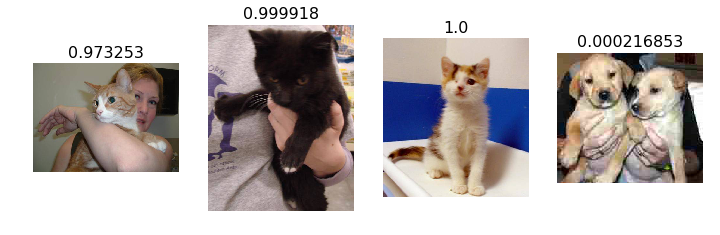

In [52]:
# 1 - correct labels
correct_idx = np.where(val_pred_lbls==val_lbls)[0]
# randomize
correct_idx_sample = np.random.permutation(correct_idx)[:n_view]
# plot 
plots_idx(correct_idx_sample, val_pred_probs[correct_idx_sample])

In [ ]:
# 2 - random incorrect labels
incorrect_idx = np.where(val_pred_lbls!=val_lbls)[0]
# randomize
incorrect_idx_sample = np.random.permutation(incorrect_idx)[:n_view]
# plot 
plots_idx(incorrect_idx_sample, val_pred_probs[incorrect_idx_sample])

In [ ]:
# 3 - Most correct dogs
correct_dogs_idx = np.where((val_pred_lbls==1) & (val_pred_lbls==val_lbls))[0]
most_correct_dogs = np.argsort(val_pred_probs[correct_dogs_idx])[:n_view]
# plot 
plots_idx(correct_dogs_idx[most_correct_dogs], val_pred_probs[correct_dogs_idx][most_correct_dogs])


In [ ]:
# 3b - Most correct cats
correct_cats_idx = np.where((val_pred_lbls==0) & (val_pred_lbls==val_lbls))[0]
most_correct_cats = np.argsort(val_pred_probs[correct_cats_idx])[::-1][:n_view] # desc sort
# plot 
plots_idx(correct_cats_idx[most_correct_cats], val_pred_probs[correct_cats_idx][most_correct_cats])


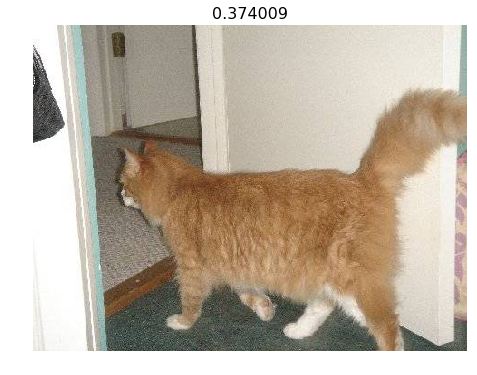

In [53]:
# 4 - Most Incorrect predictions. First, those that are most confident are cats but are dogs
incorrect_dogs_idx = np.where((val_pred_lbls==0) & (val_pred_lbls!=val_lbls))[0]
most_incorrect_dogs = np.argsort(val_pred_probs[incorrect_dogs_idx])[::-1][:n_view] # desc sort
# plot 
plots_idx(incorrect_dogs_idx[most_incorrect_dogs], val_pred_probs[incorrect_dogs_idx][most_incorrect_dogs])

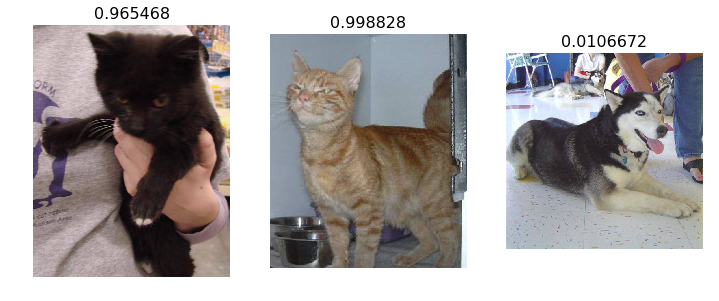

In [31]:
# 4b -  Most Incorrect predictions.Those that are most confident are dogs but are cats
incorrect_cats_idx = np.where((val_pred_lbls==1) & (val_pred_lbls!=val_lbls))[0]
most_incorrect_cats = np.argsort(val_pred_probs[incorrect_cats_idx])[:n_view] # smallest
# plot 
plots_idx(incorrect_cats_idx[most_incorrect_cats], val_pred_probs[incorrect_cats_idx][most_incorrect_cats])

In [55]:
# 5 - The most uncertain labels (ie those with probability closest to 0.5)
uncertainty = np.abs(0.5-val_pred_probs)
most_uncertain = np.argsort(uncertainty)[:n_view] # argsort returns an index array
# plot 
plots_idx(most_uncertain, val_pred_probs[most_uncertain])

array([ 0.4999,  0.5   ,  0.5   ,  0.5   ,  0.4733,  0.5   ,  0.5   ,  0.126 ,  0.4993,  0.5   ,
        0.4977,  0.4985,  0.4998,  0.4969,  0.5   ,  0.4999,  0.4818,  0.4711,  0.499 ,  0.4998], dtype=float32)

Let's plot a confusion matrix. We'll use built-in funcitonality from scikit-learn

[[10  1]
 [ 0  9]]


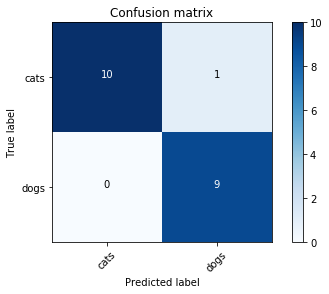

In [57]:
cm = confusion_matrix(val_lbls, val_pred_lbls)
# Use the utils helper funciton to visualize
plot_confusion_matrix(cm, val_batches.class_indices)